In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx

from opt_utils import *
from linalg_utils import *

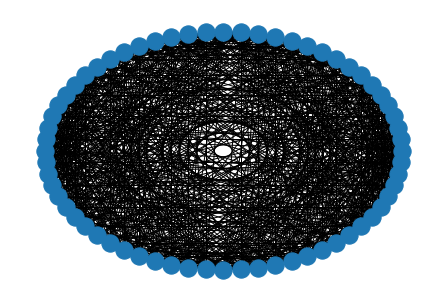

In [2]:
graph_file = "hamming6-4.mtx"
graph_type = 1

G = nx.complement(load_graph(graph_file, graph_type))
n = len(G)

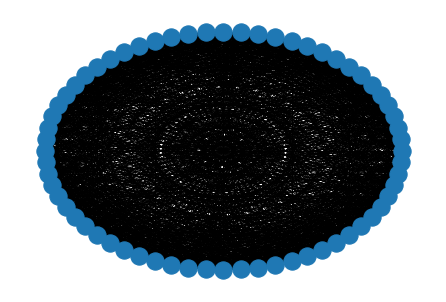

In [3]:
nx.draw(G, nx.circular_layout(G))


## Lovasz

In [4]:
prob_lovasz, Z = lovasz_sdp(G)

In [5]:
Z_val = remove_small_eigenvalues(Z.value)

In [6]:
Z_center = 1 / n * np.eye(n)

### Fixed point iteration

In [7]:
fixed_point_iteration(prob_lovasz, Z, -Z_center)

initial objective: 5.333333
initial eigenvalues:
[-7.20391460e-12 -7.20391291e-12 -7.20391171e-12 -7.20390619e-12
 -7.20390367e-12 -7.20390051e-12 -6.93764491e-12 -6.93764326e-12
 -6.93763941e-12 -6.93763799e-12 -6.93763286e-12 -6.93763190e-12
  7.81967705e-12  7.81967822e-12  7.81967904e-12  7.81968005e-12
  7.81968355e-12  7.81968393e-12  7.81968474e-12  7.81968689e-12
  7.81968820e-12  7.81969103e-12  7.81969167e-12  7.81969248e-12
  7.81969699e-12  7.81969918e-12  7.81970225e-12  7.97232730e-12
  7.97232786e-12  7.97232961e-12  7.97233235e-12  7.97233378e-12
  7.97233448e-12  7.97233550e-12  7.97233596e-12  7.97233831e-12
  7.97233876e-12  7.97234030e-12  7.97234109e-12  7.97234517e-12
  7.97234721e-12  7.97234910e-12  4.16666666e-02  4.16666666e-02
  4.16666666e-02  4.16666666e-02  4.16666666e-02  4.16666666e-02
  4.16666666e-02  4.16666666e-02  4.16666666e-02  4.16666666e-02
  4.16666667e-02  4.16666667e-02  4.16666667e-02  4.16666667e-02
  4.16666667e-02  4.16666667e-02  4.16666

In [8]:
Z_fixed_point = Z.value
Z.value = Z_val

In [9]:
try:
    Z_vec = recover_incidence_vector(Z_fixed_point, "lovasz")
    nx.draw(G, nx.circular_layout(G), node_color=Z_vec)
except:
    print("recovery failed")

AssertionError: 

## Grotschel

In [10]:
prob_grotschel, X, X_plus = grotschel_sdp(G)

In [11]:
X_val = remove_small_eigenvalues(X.value)

In [12]:
prob_center_grotschel = cp.Problem(cp.Maximize(cp.log_det(X_plus)), prob_grotschel.constraints)

prob_center_grotschel.solve()

X_center = X.value
X.value = X_val

In [13]:
X_center

array([[ 5.62610927e-02,  2.98015517e-12,  2.98967256e-12, ...,
         1.87444184e-03,  1.87444118e-03, -9.29055755e-03],
       [ 2.98015517e-12,  5.62611912e-02,  2.75741192e-12, ...,
         9.83518420e-03, -9.29047802e-03,  1.87440302e-03],
       [ 2.98967256e-12,  2.75741192e-12,  5.62611765e-02, ...,
        -9.29052088e-03,  9.83517393e-03,  1.87439463e-03],
       ...,
       [ 1.87444184e-03,  9.83518420e-03, -9.29052088e-03, ...,
         5.62608916e-02,  2.28347518e-12,  2.63848441e-12],
       [ 1.87444118e-03, -9.29047802e-03,  9.83517393e-03, ...,
         2.28347518e-12,  5.62608883e-02,  2.62790555e-12],
       [-9.29055755e-03,  1.87440302e-03,  1.87439463e-03, ...,
         2.63848441e-12,  2.62790555e-12,  5.62611669e-02]])

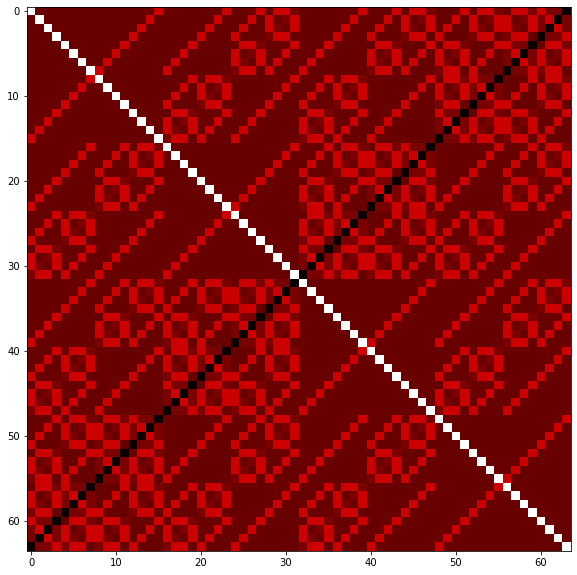

In [14]:
plot_matrix_heatmap(X_center)

### Fixed point iteration

In [15]:
fixed_point_iteration(prob_grotschel, X, -X_center)

initial objective: 5.333333
initial eigenvalues:
[-1.43626138e-16 -9.64113085e-17 -8.57979530e-17 -8.17837249e-17
 -7.84372013e-17 -7.24968098e-17 -6.37300179e-17 -6.00193817e-17
 -5.71934454e-17 -5.51702324e-17 -5.15010457e-17 -4.36398863e-17
 -4.17819089e-17 -3.61520820e-17 -3.41376150e-17 -2.81910043e-17
 -2.45177592e-17 -2.10579646e-17 -1.89165767e-17 -1.56046870e-17
 -1.17484588e-17 -8.54811375e-18 -5.42906875e-18 -1.35408565e-18
  6.65960900e-18  9.34431580e-18  1.09364033e-17  2.04463881e-17
  2.21545623e-17  2.47964031e-17  2.75387146e-17  2.92946701e-17
  3.13437749e-17  3.69763878e-17  4.04243847e-17  5.00055740e-17
  5.18904756e-17  6.10996681e-17  6.78667677e-17  7.99535179e-17
  8.87175035e-17  1.14177173e-16  2.22222220e-01  2.22222220e-01
  2.22222220e-01  2.22222220e-01  2.22222220e-01  2.22222220e-01
  2.22222220e-01  2.22222220e-01  2.22222220e-01  2.22222220e-01
  2.22222220e-01  2.22222220e-01  2.22222220e-01  2.22222220e-01
  2.22222220e-01  2.22222220e-01  2.22222

In [16]:
X_fixed_point = X.value
X.value = X_val

In [18]:
try:
    X_vec = recover_incidence_vector(X_fixed_point, "grotschel")
    nx.draw(G, nx.circular_layout(G), node_color=X_vec)
except:
    print("recovery failed")

recovery failed


## Benson & Ye

In [19]:
prob_benson, V = benson_sdp(G)

In [20]:
V_val = remove_small_eigenvalues(V.value)

In [21]:
prob_center_benson = cp.Problem(cp.Maximize(cp.log_det(V)), prob_benson.constraints)

prob_center_benson.solve()

V_center = V.value
V.value = V_val

### Fixed point iteration

In [22]:
fixed_point_iteration(prob_benson, V, -V_center)

initial objective: 5.333333
initial eigenvalues:
[-4.29001408e-15 -7.67712865e-16 -6.66959469e-16 -5.76227933e-16
 -5.21747525e-16 -4.78487848e-16 -4.39923344e-16 -4.22765599e-16
 -3.95194163e-16 -3.45140596e-16 -3.09436188e-16 -2.82959042e-16
 -2.49849629e-16 -2.16140421e-16 -1.95243516e-16 -1.67425525e-16
 -1.52611924e-16 -1.35413930e-16 -1.10199499e-16 -6.88525772e-17
 -3.09296224e-17 -5.00729319e-18  1.70771124e-17  2.65769316e-17
  6.37968521e-17  9.47349620e-17  1.14916627e-16  1.34008960e-16
  1.69418622e-16  2.03421432e-16  2.28796051e-16  2.54710201e-16
  2.90365144e-16  3.17310467e-16  3.61667892e-16  3.81240991e-16
  4.04761678e-16  4.23629818e-16  4.90989461e-16  5.18276985e-16
  5.75796623e-16  6.34142175e-16  2.73746631e-15  8.88888560e-01
  8.88888560e-01  8.88888560e-01  8.88888560e-01  8.88888560e-01
  8.88888560e-01  8.88888560e-01  8.88888560e-01  8.88888560e-01
  8.88888560e-01  8.88889217e-01  8.88889217e-01  8.88889217e-01
  8.88889217e-01  8.88889217e-01  8.88889

In [23]:
V_fixed_point = V.value
V.value = V_val

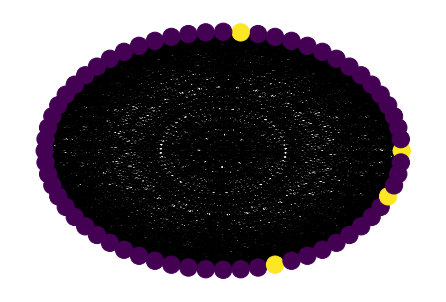

In [24]:
try:
    V_vec = recover_incidence_vector(V_fixed_point, "benson")
    nx.draw(G, nx.circular_layout(G), node_color=V_vec)
except:
    print("recovery failed")

### Hyperplane rounding

In [25]:
benson_cost_mat = np.block([[0.5 * np.eye(n), np.array([[0.25]] * n)], [np.array([[0.25]] * n).T, 0]])
benson_cost = lambda v : np.trace(benson_cost_mat @ np.outer(v, v))

max_cost = -np.Inf
max_v = None
for i in range(100):
    _, v = hyperplane_rounding(decompose_psd(V_val), benson_cost, n_iter=1)
    for (i,j) in G.edges:
        if np.abs(v[i] + v[j] + v[n]) != 1:
            if np.abs(v[i] - v[n]) > np.abs(v[j] - v[n]):
                v[i] = -v[i]
            else:
                v[j] = -v[j]
    current_cost = benson_cost(v)
    if current_cost > max_cost:
        max_cost = current_cost
        max_v = v

max_v *= max_v[n]
max_v = max_v[0:-1]

In [26]:
max_cost

4.0

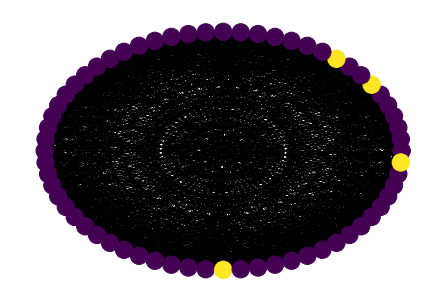

In [27]:
nx.draw(G, nx.circular_layout(G), node_color=max_v)

## Gruber & Rendl greedy algorithm

In [29]:
greedy_z = greedy_stable_set_rounding(Z_val, G)
np.sum(greedy_z)

4.0

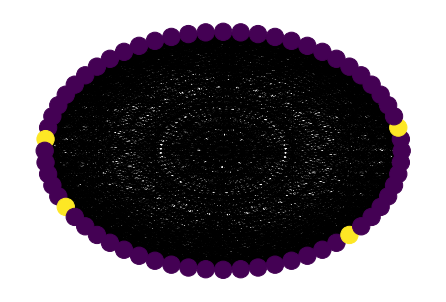

In [30]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_z)

In [31]:
greedy_x = greedy_stable_set_rounding(X_val, G)
np.sum(greedy_x)

4.0

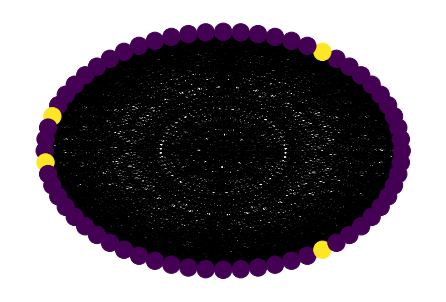

In [32]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_x)

In [33]:
len(nx.maximal_independent_set(G))

2